In [1]:
import os
import sys
import numpy as np
import scipy as sp
from scipy import optimize
from scipy.optimize import leastsq
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import mdtraj as md

In [2]:
def read_cs_md(data):
 confd = { 'HA': { },
          'CA': { },
          'CB': { },
          'C': { },
          'H': { },
          'HA2':{ },
          'HA3':{ },
          'N': { }}
 for lines in open(data, "r").readlines():
        riga=lines.strip().split(",")
        #riga=lines.strip().split(" ")
        # key dictionary
        key=riga[0]
        key2=riga[1]
        confd[key2][key]=[] 
        timeseries=np.asarray(riga[2:-1]).astype(float)
        confd[key2][key]=timeseries
 return(confd)

def read_exp_cs(data):
 confd = { 'HA': { },
          'CA': { },
          'CB': { },
          'C': { },
          'H': { },
          'HA2':{ },
          'HA3':{ },
          'N': { }}
 for lines in open(data, "r").readlines():
        #riga=lines.strip().split(",")
        riga=lines.strip().split(" ")
        # key dictionary
        key=riga[0]
        key2=riga[1]
        confd[key2][key]=[]
        confd[key2][key] += map(float, [float(riga[2])])
 return(confd)

def add_md_data(data,dict,key):
  dict[key]={}
  for lines in open(data, "r").readlines():
        riga=lines.strip().split(",")
        #riga=lines.strip().split(" ")
        key2=riga[0]
        timeseries=np.asarray(riga[1:-1]).astype(float)
        dict[key][key2]=[]
        dict[key][key2]=(timeseries)
  return(dict)

def add_exp_data(data,dict,key):
  dict[key]={}
  for lines in open(data, "r").readlines():
        #riga=lines.strip().split(",")
        riga=lines.strip().split(" ")
        key2=riga[0]
        dict[key][key2]=[]
        dict[key][key2] += map(float, [float(riga[1])])
  return(dict)

def add_md_scalar(data,dict,key):
  dict[key]={}
  dict[key][0]=np.loadtxt(data)
  return(dict)

def add_md_scalar_skip0(data,dict,key):
  dict[key]={}
  dict[key][0]=np.loadtxt(data)[0:-1]
  return(dict)

def add_exp_scalar(data,dict,key):
  dict[key]={}
  dict[key][0]=[data]
  return(dict)

def scale_rdc_Q(exp,calc):
     def residuals(p,y,x):
         c = p
         err = ((c*y)-x)
         return err
     p0=0.0001
     exp  = np.trim_zeros(exp)
     calc = np.trim_zeros(calc)
        
     Q_i=(np.sum(np.square(exp-calc))/(np.sum(np.square(exp))))**.5
     rmsd_i=(sum(np.square((exp-calc)))/(len(exp)))**0.5
    
     c,d=leastsq(residuals,p0,args=(calc,exp))
     fit=c*calc
     Q_f=(np.sum(np.square(exp-fit))/(np.sum(np.square(exp))))**.5
     rmsd_f=(sum(np.square((exp-fit)))/(len(exp)))**0.5
     return Q_i,rmsd_i,Q_f,rmsd_f,fit

In [3]:
expdata=read_exp_cs('/Users/paulrobustelli/Reweight/Test_Ab40_a99SBdisp/Exp/CS.exp.dat')
compdata=read_cs_md('/Users/paulrobustelli/Reweight/Test_Ab40_a99SBdisp/chemical_shifts.all.csv')

expdata=add_exp_data('/Users/paulrobustelli/Reweight/Test_Ab40_a99SBdisp/Exp/RDC.exp.dat',expdata,'RDC')
compdata=add_md_data('/Users/paulrobustelli/Reweight/Test_Ab40_a99SBdisp/RDC.all.csv',compdata,'RDC')

expdata=add_exp_data('/Users/paulrobustelli/Reweight/Test_Ab40_a99SBdisp/Exp/JHNHA.exp.dat',expdata,'JHNHA')
compdata=add_md_data('/Users/paulrobustelli/Reweight/Test_Ab40_a99SBdisp/J_HNHA0.all.csv',compdata,'JHNHA')

expdata=add_exp_scalar(1.25,expdata,'Rg')
compdata=add_md_scalar_skip0('/Users/paulrobustelli/Reweight/Test_Ab40_a99SBdisp/Ab40_a99SBdisp_ss_rg_dsspfull/Rgyr-CA.dat',compdata,'Rg')


In [15]:
#Set Data For Reweighting and Validation
Reweight_Data=['CA']
#Reweight_Data=['CA','CB','H','N','HA','Rg']
Validation_Data=['JHNHA','CB','H','N','HA','RDC','Rg']
#STRENGTH OF THE RESTRAINT
sigma_m=float(10.0)

#Validation_Data=['HA','CA','CB','H','N']
#Reweight_Data=['RDC','JHNHA']
compare=[]
exp_r=[] 
traj_r=[]
err_r=[]
data_r_t=[]
data_r_type={}

traj_v=[]
exp_v=[]
data_v_t=[]
data_v_type={}
err_v=[]

#PREFACTORS FOR ERROR ESTIMATES FOR EACH EXPERIMENTAL DATA
err_d = { 'HA': 0.1,
          'CA': 0.2,
          'CB': 0.2,
          'C':  0.2,
          'H':  0.1,
          'HA2': 0.1,
          'HA3': 0.1,
          'N': 0.5 ,
          'RDC': 0.5 ,
          'Rg': 0.01,
          'JHNHA': 0.25}

#For Debugging 
compare_dict_r = { 'HA': { },
          'CA': { },
          'CB': { },
          'C': { },
          'H': { },
          'HA2':{ },
          'HA3':{ },
          'N': { },
          'RDC': {},
          'Rg' : {},       
          'JHNHA': {}}

#Also For Debugging 
compare_dict_v = { 'HA': { },
          'CA': { },
          'CB': { },
          'C': { },
          'H': { },
          'HA2':{ },
          'HA3':{ },
          'N': { },
          'RDC': {},
          'JHNHA': {},
          'Rg' : {}}


#Process Reweight data into arrays
for key in Reweight_Data:   
 for key2 in expdata[key]:
  #print(key,key2,expdata[key][key2][0])
  #Check if Experimental Value is 0, if not retrieve the MD timeseries 
  if expdata[key][key2][0]!=0:  
   if key2 in compdata[key]:
    if compdata[key][key2][0]!=0:
     compare_dict_r[key][key2]=([expdata[key][key2][0],compdata[key][key2]])
     traj_r.append(compdata[key][key2])
     exp_r.append(expdata[key][key2][0])
     err_r.append(err_d[key]) 
     data_r_t.append(str(key))

for key in Reweight_Data: 
   data_id=np.zeros(len(data_r_t)) 
   for i, id in enumerate(data_r_t): 
     if id==str(key):
      data_id[i]=float(1)
   data_r_type[key]=data_id 

#Process Validation data into arrays
for key in Validation_Data:   
 for key2 in expdata[key]:
  if expdata[key][key2][0]!=0:
   if key2 in compdata[key]:
    if compdata[key][key2][0]!=0:
    #This is a hack so it doesn't choke for non-residue specific data read in as an array
    #if np.average(compdata[key][key2][0])!=0:
     compare_dict_v[key][key2]=([expdata[key][key2][0],compdata[key][key2]])
     traj_v.append(compdata[key][key2])
     exp_v.append(expdata[key][key2][0])
     err_v.append(err_d[key]) 
     data_v_t.append(str(key))

for key in Validation_Data: 
   data_id=np.zeros(len(data_v_t)) 
   for i, id in enumerate(data_v_t): 
     if id==str(key):
      data_id[i]=float(1)
   data_v_type[key]=data_id 



In [16]:
#data for reweighting - 1 column per exp data - 1 row per MD frame
traj_r=np.asarray(traj_r)
traj_v=np.asarray(traj_v)
# experimental data for reweighting - 1 column per exp data - 1 row
obs_exp_r=np.asarray(exp_r)
obs_exp_v=np.asarray(exp_v)
# predictor/experimental errors for reweighting - 1 column per exp data - 1 row
err_r=np.asarray(err_r)
err_v=np.asarray(err_v)

#Uniform Initial Weights For Each Frame
weight_bias=np.ones(len(traj_r[0]))
#sigma_m=float(0.1)
# calculate sigma vector
sigma=sigma_m*err_r
#print(sigma)
#number of observables
nobs_r=len(sigma)
nobs_v=len(obs_exp_v)
#number of frames
nframes=len(traj_r[0])

print('# of Frames:',nframes)

print('Reweight Data Points:',nobs_r)
for key in data_r_type:
    print(str(key)+':',sum(data_r_type[key]))

print('Validation Data Points:',nobs_v)
for key in data_v_type:
    print(str(key)+':',sum(data_v_type[key]))



# of Frames: 29976
Reweight Data Points: 38
CA: 38.0
Validation Data Points: 200
JHNHA: 36.0
CB: 32.0
H: 37.0
N: 37.0
HA: 32.0
RDC: 25.0
Rg: 1.0


In [17]:
# maxent calculation

# function to be minimized:
# attention: it reads global variables weight_bias, obs_exp, and sigma
def func(l):
    l = np.array(l) # ensure array
    weight_all = +weight_bias # copy
    weight_all -= np.dot(l,traj_r) # maxent correction
    shift_all = np.max(weight_all) # shift to avoid overflow
    weight_all = np.exp(weight_all - shift_all) # compute weights

    # same stuff with original ensemble
    weight_0 = +weight_bias # copy
    shift_0 = np.max(weight_0) # shift to avoid overflow
    weight_0 = np.exp(weight_0 - shift_0) # compute weights

    # Gamma function in maxent:
    #Shifts to avoid overflows
    f = np.log(np.sum(weight_all) / np.sum(weight_0)) + shift_all - shift_0 + np.dot(l,obs_exp_r)

    # derivative of Gamma function:
    der = obs_exp_r - np.dot(traj_r,weight_all) / np.sum(weight_all) # derivative with respect to l

    # regularization term
    # REGULARIZE
    f += 0.5*np.sum(sigma*l**2)
    der += sigma*l

    return(f,der)

In [18]:
# perform minimization
#res.X lagrange multiplier
res = sp.optimize.minimize(func, np.zeros((nobs_r,)), method='L-BFGS-B',jac=True)


# ANALYSIS
# calculate normalized initial weights
initial_weights=weight_bias
initial_weights-=np.max(initial_weights)
initial_weights=np.exp(initial_weights)
initial_weights/=np.sum(initial_weights)
# initial average observables for reweighting and validation
initial_obs_r=np.dot(traj_r,initial_weights)
initial_obs_v=np.dot(traj_v,initial_weights)

# various initial RMSE
print("Initial RMSE reweight data ")
print(" * Total :     %6.3lf" % np.sqrt(np.mean((initial_obs_r-obs_exp_r)**2)))

for t in data_r_type:
    print(" *    %2s :" % t, end = '')
    print("     %6.3lf" % np.sqrt(np.sum((initial_obs_r-obs_exp_r)**2*data_r_type[t])/np.sum(data_r_type[t])))
    if str(t)=='RDC': 
      qi,rms_i,qf,rms_f,rdc_scale_i=scale_rdc_Q(initial_obs_r*data_r_type['RDC'],obs_exp_r*data_r_type['RDC'])
      #print(" *    RDC scaled RMSD:", end = '')
      #print(" %6.3lf" % rms_f)
      print(" *    RDC scaled Q:", end = '')
      print(" %6.3lf" % qf)
    
print("Initial RMSE validation data")
print(" * Total :     %6.3lf" % np.sqrt(np.mean((initial_obs_v-obs_exp_v)**2)))

for t in data_v_type:
    print(" *    %2s :" % t, end= '')
    print("     %6.3lf" % np.sqrt(np.sum((initial_obs_v-obs_exp_v)**2*data_v_type[t])/np.sum(data_v_type[t])))
    if str(t)=='RDC': 
      qi,rms_i,qf,rms_f,rdc_scale_i=scale_rdc_Q(initial_obs_v*data_v_type['RDC'],obs_exp_v*data_v_type['RDC'])
      #print(" *    RDC scaled RMSD:", end = '')
      #print(" %6.3lf" % rms_f)
      print(" *    RDC scaled Q:", end = '')
      print(" %6.3lf" % qf)
    
print("minimization worked:",res.success)
#print("lagrangian multipliers:",res.x)
# calculate normalized final weights
final_weights=(weight_bias-np.dot(res.x,traj_r))
final_weights-=np.max(final_weights)
final_weights=np.exp(final_weights)
final_weights/=np.sum(final_weights)
# final average observables for reweighting and validation
final_obs_r=np.dot(traj_r,final_weights)
final_obs_v=np.dot(traj_v,final_weights)
# various final RMSE
print("Final RMSE reweight data")
print(" * Total :     %6.3lf" % np.sqrt(np.mean((final_obs_r-obs_exp_r)**2)))

for t in data_r_type:
    print(" *    %2s :" % t, end = '')
    print("     %6.3lf" % np.sqrt(np.sum((final_obs_r-obs_exp_r)**2*data_r_type[t])/np.sum(data_r_type[t])))
    if str(t)=='RDC': 
      qi,rms_i,qf,rms_f,rdcs_scale_f=scale_rdc_Q(final_obs_r*data_r_type['RDC'],obs_exp_r*data_r_type['RDC'])
      #print(" *    RDC RMSE_scale:", end = '')
      #print(" %6.3lf" % rms_f)
      print(" *    RDC Q_scaled:", end = '')
      print(" %6.3lf" % qf)

print("Final RMSE validation data")
print(" * Total :     %6.3lf" % np.sqrt(np.mean((final_obs_v-obs_exp_v)**2)))

for t in data_v_type:
    print(" *    %2s :" % t, end = '')
    print("     %6.3lf" % np.sqrt(np.sum((final_obs_v-obs_exp_v)**2*data_v_type[t])/np.sum(data_v_type[t])))
    if str(t)=='RDC': 
      qi,rms_i,qf,rms_f,rdc_scale_f=scale_rdc_Q(final_obs_v*data_v_type['RDC'],obs_exp_v*data_v_type['RDC'])
      #print(" *    RDC RMSE_scale:", end = '')
      #print(" %6.3lf" % rms_f)
      print(" *    RDC Q_scaled:", end = '')
      print(" %6.3lf" % qf)
    

    
# Kish effective size
Ks_b = np.average(initial_weights)**2/np.average(initial_weights**2)
Ks_a = np.average(final_weights)**2/np.average(final_weights**2)
print("Initial Kish size : %9.6lf %d" % (Ks_b, Ks_b*nframes))
print("Reweighted Kish size : %9.6lf %d" % (Ks_a, Ks_a*nframes))
print("Kish ratio : %9.6lf" % (Ks_a/Ks_b*100.0))

# print final weights to file
f=open("test_w_final-"+str(sigma_m)+".dat", "w")
for w in final_weights:
    f.write("%e\n" % w)
f.close()


Initial RMSE reweight data 
 * Total :      0.472
 *    CA :      0.472
Initial RMSE validation data
 * Total :      1.082
 *    JHNHA :      0.635
 *    CB :      0.404
 *     H :      0.295
 *     N :      1.543
 *    HA :      0.093
 *    RDC :      2.217
 *    RDC scaled Q:  0.503
 *    Rg :      0.116
minimization worked: True
Final RMSE reweight data
 * Total :      0.284
 *    CA :      0.284
Final RMSE validation data
 * Total :      1.025
 *    JHNHA :      0.521
 *    CB :      0.329
 *     H :      0.272
 *     N :      1.285
 *    HA :      0.080
 *    RDC :      2.304
 *    RDC Q_scaled:  0.466
 *    Rg :      0.187
Initial Kish size :  1.000000 29975
Reweighted Kish size :  0.409542 12276
Kish ratio : 40.954225


CA


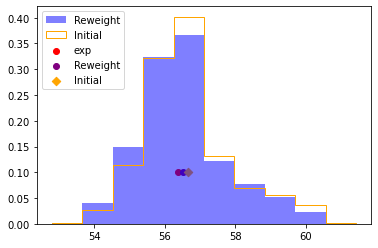

In [20]:
vp=9
print(data_r_t[vp])
plt.hist(traj_r[vp],weights=final_weights,density='true',alpha=0.5,label='Reweight',color='blue')
plt.hist(traj_r[vp],density='true',color='orange',histtype='step',label='Initial')
plt.scatter(obs_exp_r[vp],0.1,color='red',label='exp')
plt.scatter(final_obs_r[vp],0.1,color='purple',label='Reweight')
plt.scatter(initial_obs_r[vp],0.1,color='orange',marker='D',label='Initial')
plt.legend(loc='upper left')
#print(expdata['JHNHA'])

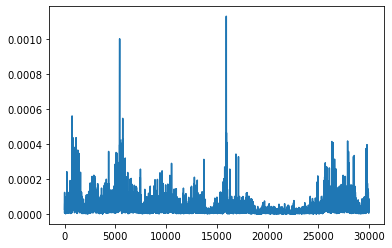

In [21]:
#Compare Weights
#All_weights=final_weights
#fig, ((ax1, ax2), (ax3,ax4)) = plt.subplots(2, 2)
plt.plot(final_weights)
#ax2.plot(JHNHA_weights)
#ax3.plot(All_weights)
#ax4.plot(final_weights)



CA
RMSD_initial: 0.472 RMSD_final: 0.284


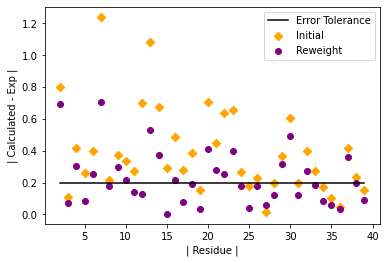

In [24]:
#Plot Fitting Data
#t='CA'

#subplots_adjust(hspace=0.000)
#number_of_subplots=len(data_r_type)
#for i,v in enumerate(xrange(number_of_subplots)):
#    v = v+1
#    ax1 = subplot(number_of_subplots,1,v)
#    ax1.plot(x,y)

t='CA'
#for t in data_r_type:
print(t)
resid=[]
exp=[]
calc=[]    
err_fit=[]    
err=err_d[t]
for i,id in enumerate(compare_dict_r[t]): 
   #print(t,id,compare_dict_r[t][id][0])
   resid.append(float(id))
   exp.append(compare_dict_r[t][id][0]) 
   err_fit.append(err)
initial=np.trim_zeros(initial_obs_r*data_r_type[t])
reweight=np.trim_zeros(final_obs_r*data_r_type[t])
exp=np.trim_zeros(obs_exp_r*data_r_type[t])
#print(np.trim_zeros(exp),np.trim_zeros(calc))    
err=err_d[t]
#plt.scatter(resid,exp,color='red',label='exp')
print("RMSD_initial:%6.3lf" %(sum(np.square(initial-exp))/len(exp))**0.5,"RMSD_final:%6.3lf"%(sum(np.square(reweight-exp))/len(exp))**0.5)
if t=='RDC':
 qi_i,rms_i_i,qf_i,rms_f_i,i_fit=scale_rdc_Q(exp,initial)   
 qi_f,rms_f_f,qf_f,rms_f_f,f_fit=scale_rdc_Q(exp,reweight)   
 print("Q_inital:, RMS_initial, Q_reweight, RMS_reweight")  
 
plt.scatter(resid,np.absolute(initial-exp),color='orange',marker='D',label='Initial')   
plt.scatter(resid,np.absolute(reweight-exp),color='purple',label='Reweight')
plt.plot(resid,err_fit,color='black',label='Error Tolerance')
plt.ylabel('| Calculated - Exp |')
plt.xlabel('| Residue |')
plt.legend(loc='upper right')

#    plt.scatter(calc,exp)
#    print(" *    %2s :" % t, end = '')
#    print("     %6.3lf" % np.sqrt(np.sum((final_obs_r-obs_exp_r)**2*data_r_type[t])/np.sum(data_r_type[t])))

JHNHA
RMSD_initial: 0.635 RMSD_final: 0.521


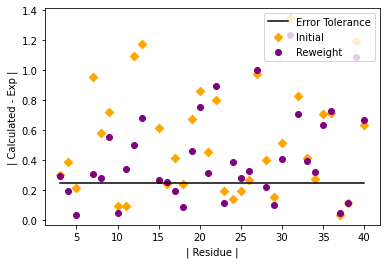

In [25]:
#Plot Validation Data
#t='CA'

#subplots_adjust(hspace=0.000)
#number_of_subplots=len(data_r_type)
#for i,v in enumerate(xrange(number_of_subplots)):
#    v = v+1
#    ax1 = subplot(number_of_subplots,1,v)
#    ax1.plot(x,y)

t='JHNHA'
#for t in data_r_type:
print(t)
resid=[]
exp=[]
calc=[]    
err_fit=[]    
err=err_d[t]
for i,id in enumerate(compare_dict_v[t]): 
   #print(t,id,compare_dict_r[t][id][0])
   resid.append(float(id))
   exp.append(compare_dict_v[t][id][0]) 
   err_fit.append(err)
initial=np.trim_zeros(initial_obs_v*data_v_type[t])
reweight=np.trim_zeros(final_obs_v*data_v_type[t])
exp=np.trim_zeros(obs_exp_v*data_v_type[t])
print("RMSD_initial:%6.3lf" %(sum(np.square(initial-exp))/len(exp))**0.5,"RMSD_final:%6.3lf"%(sum(np.square(reweight-exp))/len(exp))**0.5)
if t=='RDC':
 qi_i,rms_i_i,qf_i,rms_f_i,i_fit=scale_rdc_Q(exp,initial)   
 qi_f,rms_f_f,qf_f,rms_f_f,f_fit=scale_rdc_Q(exp,reweight)   
 print("Q_inital:, RMS_initial, Q_reweight, RMS_reweight")  
 print("%6.3lf %6.3lf %6.3lf %6.3lf" % (qf_i,rms_f_i,qf_f,rms_f_f))
#print(np.trim_zeros(exp),np.trim_zeros(calc))    
err=err_d[t]
#plt.scatter(resid,exp,color='red',label='exp')
plt.scatter(resid,np.absolute(initial-exp),color='orange',marker='D',label='Initial')   
plt.scatter(resid,np.absolute(reweight-exp),color='purple',label='Reweight')
plt.plot(resid,err_fit,color='black',label='Error Tolerance')
plt.ylabel('| Calculated - Exp |')
plt.xlabel('| Residue |')
plt.legend(loc='upper right')

CB
RMSD_initial: 0.404 RMSD_final: 0.329


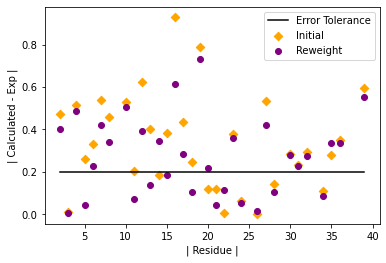

In [26]:
t='CB'
#for t in data_r_type:
print(t)
resid=[]
exp=[]
calc=[]    
err_fit=[]    
err=err_d[t]
for i,id in enumerate(compare_dict_v[t]): 
   #print(t,id,compare_dict_r[t][id][0])
   resid.append(float(id))
   exp.append(compare_dict_v[t][id][0]) 
   err_fit.append(err)
initial=np.trim_zeros(initial_obs_v*data_v_type[t])
reweight=np.trim_zeros(final_obs_v*data_v_type[t])
exp=np.trim_zeros(obs_exp_v*data_v_type[t])
print("RMSD_initial:%6.3lf" %(sum(np.square(initial-exp))/len(exp))**0.5,"RMSD_final:%6.3lf"%(sum(np.square(reweight-exp))/len(exp))**0.5)
if t=='RDC':
 qi_i,rms_i_i,qf_i,rms_f_i,i_fit=scale_rdc_Q(exp,initial)   
 qi_f,rms_f_f,qf_f,rms_f_f,f_fit=scale_rdc_Q(exp,reweight)   
 print("Q_inital:, RMS_initial, Q_reweight, RMS_reweight")  
 print("%6.3lf %6.3lf %6.3lf %6.3lf" % (qf_i,rms_f_i,qf_f,rms_f_f))
#print(np.trim_zeros(exp),np.trim_zeros(calc))    
err=err_d[t]
#plt.scatter(resid,exp,color='red',label='exp')
plt.scatter(resid,np.absolute(initial-exp),color='orange',marker='D',label='Initial')   
plt.scatter(resid,np.absolute(reweight-exp),color='purple',label='Reweight')
plt.plot(resid,err_fit,color='black',label='Error Tolerance')
plt.ylabel('| Calculated - Exp |')
plt.xlabel('| Residue |')
plt.legend(loc='upper right')

HA
RMSD_initial: 0.093 RMSD_final: 0.080


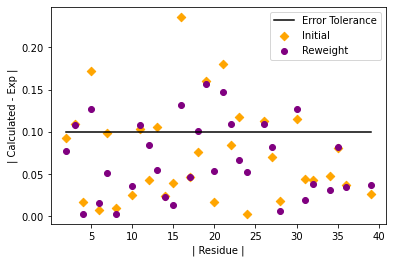

In [27]:
t='HA'
#for t in data_r_type:
print(t)
resid=[]
exp=[]
calc=[]    
err_fit=[]    
err=err_d[t]
for i,id in enumerate(compare_dict_v[t]): 
   #print(t,id,compare_dict_r[t][id][0])
   resid.append(float(id))
   exp.append(compare_dict_v[t][id][0]) 
   err_fit.append(err)
initial=np.trim_zeros(initial_obs_v*data_v_type[t])
reweight=np.trim_zeros(final_obs_v*data_v_type[t])
exp=np.trim_zeros(obs_exp_v*data_v_type[t])
print("RMSD_initial:%6.3lf" %(sum(np.square(initial-exp))/len(exp))**0.5,"RMSD_final:%6.3lf"%(sum(np.square(reweight-exp))/len(exp))**0.5)
if t=='RDC':
 qi_i,rms_i_i,qf_i,rms_f_i,i_fit=scale_rdc_Q(exp,initial)   
 qi_f,rms_f_f,qf_f,rms_f_f,f_fit=scale_rdc_Q(exp,reweight)   
 print("Q_inital:, RMS_initial, Q_reweight, RMS_reweight")  
 print("%6.3lf %6.3lf %6.3lf %6.3lf" % (qf_i,rms_f_i,qf_f,rms_f_f))
#print(np.trim_zeros(exp),np.trim_zeros(calc))    
err=err_d[t]
#plt.scatter(resid,exp,color='red',label='exp')
plt.scatter(resid,np.absolute(initial-exp),color='orange',marker='D',label='Initial')   
plt.scatter(resid,np.absolute(reweight-exp),color='purple',label='Reweight')
plt.plot(resid,err_fit,color='black',label='Error Tolerance')
plt.ylabel('| Calculated - Exp |')
plt.xlabel('| Residue |')
plt.legend(loc='upper right')

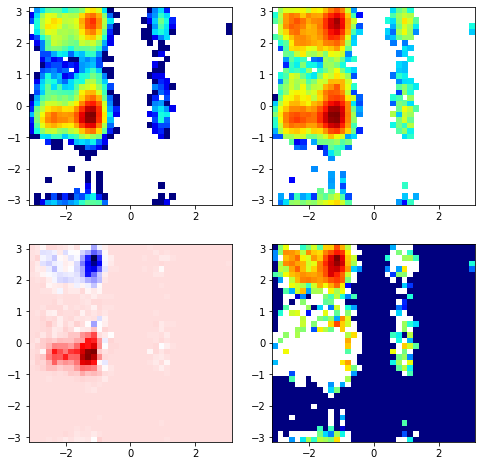

In [28]:
phipsi_dir='/Users/paulrobustelli/Reweight/Test_Ab40_a99SBdisp/Ab40_a99SBdisp_ss_rg_dsspfull/dihedral/'
residue=9
phipsi=np.loadtxt(phipsi_dir+'/PhiPsi.%s.dat'%residue)[0:-1]

fig, ax = plt.subplots(2, 2, figsize=((8,8)))
hist_i=ax[0,0].hist2d(phipsi[:,0], phipsi[:,1], bins=36,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
hist_r=ax[0,1].hist2d(phipsi[:,0], phipsi[:,1], weights=final_weights, bins=36,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
hist_init=hist_i[0]/np.sum(hist_i[0])
hist_re=hist_r[0]/np.sum(hist_r[0])
xedges=hist_i[1]
yedges=hist_i[2]
hist_diff=hist_init - hist_re
#hist_int - hist_re = hist_diff. For +hist_diff.T red is a descrease, blue is increase )
ax[1,0].pcolorfast(xedges, yedges, hist_diff.T,cmap='seismic')
# -hist_diff.T shows log plot of regions with an increase density, and regions with a decrease are blank
ax[1,1].pcolorfast(xedges, yedges, -hist_diff.T,norm=colors.LogNorm(),cmap='jet')


In [29]:
#Load some Analyses to compare before and after reweightings 
helix=np.loadtxt('/Users/paulrobustelli/Reweight/Test_Ab40_a99SBdisp/Ab40_a99SBdisp_ss_rg_dsspfull/dssp.H.dat')
sheet=np.loadtxt('/Users/paulrobustelli/Reweight/Test_Ab40_a99SBdisp/Ab40_a99SBdisp_ss_rg_dsspfull/dssp.e.dat')
helix=helix[0:-1]
sheet=sheet[0:-1]

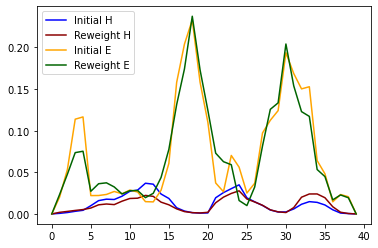

In [30]:
Hprop=np.sum(helix,axis=0).astype(float)/len(helix)
Eprop=np.sum(sheet,axis=0).astype(float)/len(sheet)

reweight_Hprop=[]
reweight_Eprop=[]
for i in range(0,len(Hprop)):    
 #reweight_Hprop.append([i,np.dot(helix[:,i],final_weights)])
 reweight_Hprop.append(np.dot(helix[:,i],final_weights))
 reweight_Eprop.append(np.dot(sheet[:,i],final_weights))

plt.plot(Hprop,color='blue',label='Initial H')
plt.plot(reweight_Hprop,color='darkred',label='Reweight H')
plt.plot(Eprop,color='orange',label='Initial E')
plt.plot(reweight_Eprop,color='darkgreen',label='Reweight E')
plt.legend(loc='upper left')

Rg Exp:  1.20+_  0.13 Rg Initial:  1.37 Rg Reweight:  1.44 


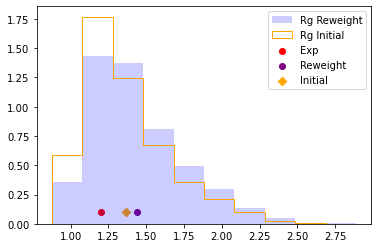

In [32]:
rg=np.loadtxt('/Users/paulrobustelli/Reweight/Test_Ab40_a99SBdisp/Ab40_a99SBdisp_ss_rg_dsspfull/Rgyr-CA.dat')
rg=rg[0:-1]
rg_i=np.dot(rg,initial_weights)
rg_r=np.dot(rg,final_weights)
rg_exp=1.20
rg_err=.13
print("Rg Exp:%6.2lf+_%6.2lf"%(rg_exp,rg_err),"Rg Initial:%6.2lf"%rg_i,"Rg Reweight:%6.2lf "%rg_r)

plt.hist(rg,weights=final_weights,density='true',alpha=0.2,label='Rg Reweight',color='blue')
plt.hist(rg,density='true',color='orange',histtype='step',label='Rg Initial')

plt.scatter(rg_exp,0.1,color='red',label='Exp')
plt.scatter(rg_r,0.1,color='purple',label='Reweight')
plt.scatter(rg_i,0.1,color='orange',marker='D',label='Initial')
plt.legend(loc='upper right')
plt.show()

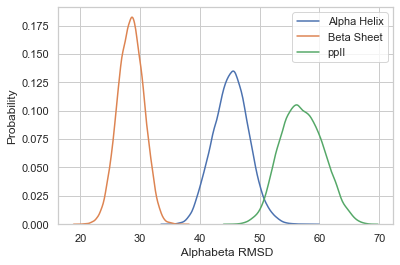

In [33]:
#https://www.plumed.org/doc-v2.5/user-doc/html/_a_l_p_h_a_b_e_t_a.html

def alphabeta_rmsd(phi,psi,phi_ref,psi_ref):
 alphabetarmsd=np.sum(0.5*(1+np.cos(psi-psi_ref)),axis=1)+np.sum(0.5*(1+np.cos(phi-phi_ref)),axis=1)
 return alphabetarmsd 

Phi_all=np.loadtxt(phipsi_dir+'/Phi.dat')[0:-1]
Psi_all=np.loadtxt(phipsi_dir+'/Psi.dat')[0:-1]

alphabeta_alpharight=alphabeta_rmsd(Phi_all,Psi_all,-1.05,-0.79)
alphabeta_betasheet=alphabeta_rmsd(Phi_all,Psi_all,2.36,-2.36)
alphabeta_ppII=alphabeta_rmsd(Phi_all,Psi_all,-1.31,2.71)

sns.set(style='whitegrid')
sns.kdeplot(data=alphabeta_alpharight,label='Alpha Helix')
sns.kdeplot(data=alphabeta_betasheet,label='Beta Sheet')
sns.kdeplot(data=alphabeta_ppII,label='ppII')

plt.xlabel(' Alphabeta RMSD',fontsize=12)
plt.ylabel('Probability',fontsize=12)
plt.legend(loc='upper right')

plt.show()

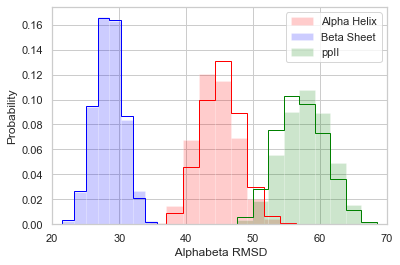

In [34]:
#fig, ax = plt.subplots(2, figsize=((8,8)))
plt.clf()
plt.hist(alphabeta_alpharight,histtype='step',density='true',color='red')
plt.hist(alphabeta_betasheet,histtype='step',density='true',color='blue')
plt.hist(alphabeta_ppII,histtype='step',density='true',color='green')

plt.hist(alphabeta_alpharight,weights=final_weights,alpha=0.2,density='true',label='Alpha Helix',color='red')
plt.hist(alphabeta_betasheet,weights=final_weights,alpha=0.2,density='true',label='Beta Sheet',color='blue')
plt.hist(alphabeta_ppII,weights=final_weights,alpha=0.2,density='true',label='ppII',color='green')

plt.xlabel(' Alphabeta RMSD',fontsize=12)
plt.ylabel('Probability',fontsize=12)
plt.legend(loc='upper right')
plt.xlim(20, 70)

plt.show()

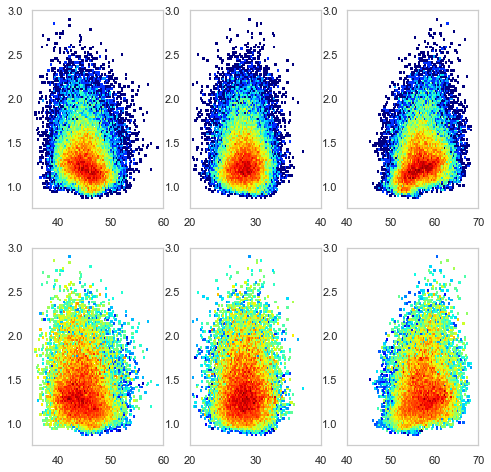

In [35]:
fig, ax = plt.subplots(2,3, figsize=((8,8)))
hist_i=ax[0,0].hist2d(alphabeta_alpharight,rg,bins=100,range=[[35,60],[0.75,3.0]],norm=colors.LogNorm(),cmap='jet')
hist_r=ax[1,0].hist2d(alphabeta_alpharight,rg,bins=100,range=[[35,60],[0.75,3.0]], weights=final_weights, norm=colors.LogNorm(),cmap='jet')

hist_i=ax[0,1].hist2d(alphabeta_betasheet,rg,bins=100,range=[[20,40],[0.75,3.0]],norm=colors.LogNorm(),cmap='jet')
hist_r=ax[1,1].hist2d(alphabeta_betasheet,rg,bins=100,range=[[20,40],[0.75,3.0]],weights=final_weights, norm=colors.LogNorm(),cmap='jet')

hist_i=ax[0,2].hist2d(alphabeta_ppII,rg,bins=100,range=[[40,70],[0.75,3.0]],norm=colors.LogNorm(),cmap='jet')
hist_r=ax[1,2].hist2d(alphabeta_ppII,rg,bins=100,range=[[40,70],[0.75,3.0]], weights=final_weights, norm=colors.LogNorm(),cmap='jet')

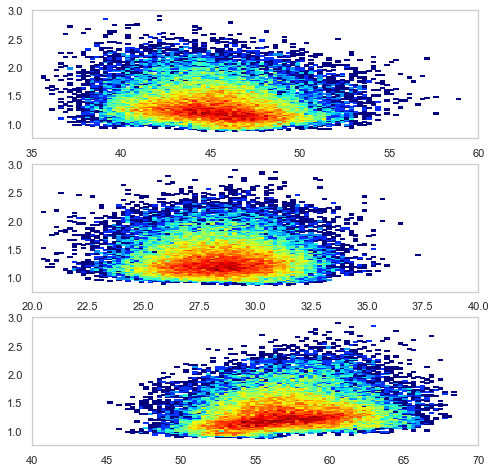

In [36]:
fig, ax = plt.subplots(3, figsize=((8,8)))
hist_i=ax[0].hist2d(alphabeta_alpharight,rg,bins=100,range=[[35,60],[0.75,3.0]],norm=colors.LogNorm(),cmap='jet')
hist_i=ax[1].hist2d(alphabeta_betasheet,rg,bins=100,range=[[20,40],[0.75,3.0]],norm=colors.LogNorm(),cmap='jet')
hist_i=ax[2].hist2d(alphabeta_ppII,rg,bins=100,range=[[40,70],[0.75,3.0]],norm=colors.LogNorm(),cmap='jet')


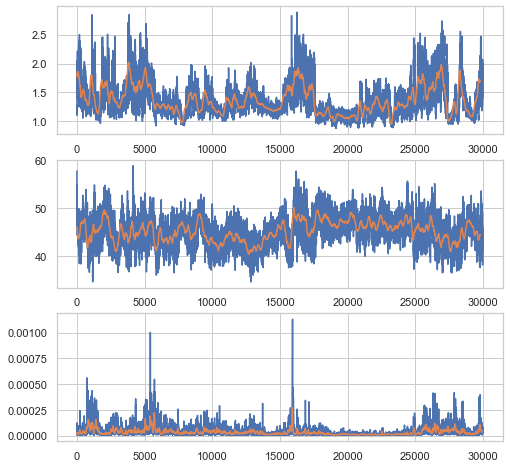

In [79]:
N=200
fig, ax = plt.subplots(3, figsize=((8,8)))
ax[0].plot(rg)
ax[0].plot(np.convolve(rg,np.ones(N)/N,mode='valid'))
ax[1].plot(alphabeta_alpharight)
ax[1].plot(np.convolve(alphabeta_alpharight,np.ones(N)/N,mode='valid'))
ax[2].plot(final_weights)
N=50
ax[2].plot(np.convolve(final_weights,np.ones(N)/N,mode='valid'))


In [41]:
pdb='/Users/paulrobustelli/Desktop/Trajectories/Reweight/Ab40_a03ws/Ab40.pdb'
trajectory='/Users/paulrobustelli/Desktop/Trajectories/Reweight/Ab40_a99SBdisp/Ab40_a99SBdisp.dcd'

trj = md.load(trajectory,top=pdb,stride=1)
trj.center_coordinates()
top = trj.topology
first_frame = 0
last_frame = trj.n_frames
n_frames=trj.n_frames

nres=[]
for res in trj.topology.residues: nres.append(res.resSeq)
sequence=(' %s' % [residue for residue in trj.topology.residues])
resname=(' %s' % [residue.name for residue in trj.topology.residues])
resindex=(' %s' % [residue.index for residue in trj.topology.residues])
prot_top=top.subset(top.select('protein'))
prot_res=[]
for res in prot_top.residues: prot_res.append(res.resSeq)
prot_resname=(' %s' % [residue.name for residue in prot_top.residues])
residues=len(set(prot_res))

#log = open("/Users/paulrobustelli/Desktop/Sa_calc.log", "w")
print("** SYSTEM INFO **\n")
print("Number of atoms: %d\n" % trj.n_atoms)
print("Number of residues: %d\n" % len(set(nres)))
print("Number of protein residues: %d\n" % len(set(prot_res)))
print("Number of frames: %d\n" % trj.n_frames)
print("Starting frame: %d\n" % first_frame)
print("Last frame: %d\n" % last_frame)
print("sequence: %s\n" % sequence)
print("residue names: %s\n" % resname)
print("residue index: %s\n" % resindex)

residues=40
residue_offset=0
residue_number = range(residue_offset, residue_offset+residues)
print("Residue Number Range:",residue_number)


** SYSTEM INFO **

Number of atoms: 598

Number of residues: 40

Number of protein residues: 40

Number of frames: 29977

Starting frame: 0

Last frame: 29977

sequence:  [ASP1, ALA2, GLU3, PHE4, ARG5, HIS6, ASP7, SER8, GLY9, TYR10, GLU11, VAL12, HIS13, HIS14, GLN15, LYS16, LEU17, VAL18, PHE19, PHE20, ALA21, GLU22, ASP23, VAL24, GLY25, SER26, ASN27, LYS28, GLY29, ALA30, ILE31, ILE32, GLY33, LEU34, MET35, VAL36, GLY37, GLY38, VAL39, VAL40, ASP1, HIS6, HIS13, HIS14]

residue names:  ['ASP', 'ALA', 'GLU', 'PHE', 'ARG', 'HIS', 'ASP', 'SER', 'GLY', 'TYR', 'GLU', 'VAL', 'HIS', 'HIS', 'GLN', 'LYS', 'LEU', 'VAL', 'PHE', 'PHE', 'ALA', 'GLU', 'ASP', 'VAL', 'GLY', 'SER', 'ASN', 'LYS', 'GLY', 'ALA', 'ILE', 'ILE', 'GLY', 'LEU', 'MET', 'VAL', 'GLY', 'GLY', 'VAL', 'VAL', 'ASP', 'HIS', 'HIS', 'HIS']

residue index:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]

Residue Number Range

In [50]:
import math
import itertools    
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, \
                  array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq

def block(x):
    # preliminaries
    d = log2(len(x))
    if (d - floor(d) != 0):
    #    print("Warning: Data size = %g, is not a power of 2." % floor(2**d))
    #    print("Truncating data to %g." % 2**floor(d) )
        x = x[:2**int(floor(d))]
    d = int(floor(d))
    n = 2**d
    s, gamma = zeros(d), zeros(d)
    mu = mean(x)
    # estimate the auto-covariance and variances 
    # for each blocking transformation
    for i in arange(0,d):
        n = len(x)
        # estimate autocovariance of x
        gamma[i] = (n)**(-1)*sum( (x[0:(n-1)]-mu)*(x[1:n]-mu) )
        # estimate variance of x
        s[i] = var(x)
        # perform blocking transformation
        x = 0.5*(x[0::2] + x[1::2])

    # generate the test observator M_k from the theorem
    M = (cumsum( ((gamma/s)**2*2**arange(1,d+1)[::-1])[::-1] )  )[::-1]

    # we need a list of magic numbers
    q =array([6.634897,  9.210340,  11.344867, 13.276704, 15.086272,
              16.811894, 18.475307, 20.090235, 21.665994, 23.209251,
              24.724970, 26.216967, 27.688250, 29.141238, 30.577914,
              31.999927, 33.408664, 34.805306, 36.190869, 37.566235,
              38.932173, 40.289360, 41.638398, 42.979820, 44.314105,
              45.641683, 46.962942, 48.278236, 49.587884, 50.892181])

    # use magic to determine when we should have stopped blocking
    for k in arange(0,d):
        if(M[k] < q[k]):
            break
    if (k >= d-1):
        print("Warning: Use more data")

    return (s[k]/2**(d-k))


In [42]:
def writhe_matrix(segment1,segment2):
 v13 = s2[:,0] - s1[:,0]
 v23 = s2[:,0] - s1[:,1]
 v24 = s2[:,1] - s1[:,1]
 v14 = s2[:,1] - s1[:,0]
 v = [v13,v23,v24,v14,v13,v23]
 e = []
 l13 = np.linalg.norm(v13,axis=1)
 l23 = np.linalg.norm(v23,axis=1)
 l24 = np.linalg.norm(v24,axis=1)
 l14 = np.linalg.norm(v14,axis=1)
 ls = [l13,l23,l24,l14]   
 for l in ls:
        if np.sum(l) == 0.0:
            return 0
 e13 = v13/l13[:,None]
 e23 = v23/l23[:,None]
 e24 = v24/l24[:,None]
 e14 = v14/l14[:,None]
 e = [e13,e23,e24,e14,e13,e23] 
    #compute the angles
 s = 0
 for i in range(1,len(e)-1):
        a = np.asarray(e[i-1])
        b =np.asarray(e[i])
        c = np.asarray(e[i+1])
        #a =e[i-1]
        #b =e[i]
        #c = e[i+1]
        v1=a-b
        v3=c-b
        #a=np.dot(v1,v3)
        a=(v1*v3).sum(axis=1)/(np.linalg.norm(v1,axis=1)*np.linalg.norm(v3,axis=1))
        #a=np.dot(v1,v3)/(np.linalg.norm(v1,axis=1)*np.linalg.norm(v3,axis=1))
        theta=np.arccos(np.clip(a, -1.0, 1.0))  
        s = s +theta
 w = np.sign(s)*2*np.pi - s
 return w

In [65]:
CAatoms=trj.topology.select('name CA')
CAdihe_index=[]
CAlabel=[]
CAang_index=[]
CAvec_index=[]
CApos=trj.xyz[:,CAatoms]

for i in range(0,len(CAatoms)):
     CAlabel.append(trj.topology.atom(CAatoms[i]).residue.resSeq)

#print(np.array(CAlabel).astype(int))


#Sum over all pairs - not just the top half of the matrix
wr_total={}
for j in range(0,len(CAlabel)-1):
 wr_total[j]={}
 v1=CApos[:,j]; v2=CApos[:,j+1];
 s1=np.empty((len(CApos),2,3))
 s1[:,0]=v1
 s1[:,1]=v2
 for k in range(0,len(CAlabel)-1):
      v3=CApos[:,k]; v4=CApos[:,k+1];
      s2=np.empty((len(CApos),2,3))
      s2[:,0]=v3
      s2[:,1]=v4
      wr_total[j][k]=writhe_matrix(s1,s2)

writhe_by_res={}
wtot=np.zeros(len(CApos[:,0]))
for i in wr_total:
    w=np.zeros(len(CApos[:,0]))
    for j in wr_total[i]:
       w+=wr_total[i][j] 
    writhe_by_res[i]=w
    wtot+=w

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]


In [66]:
#Compute Phi and Psi
indices_phi, phis = md.compute_phi(trj)
indices_psi, psis = md.compute_psi(trj)
#print(indices_phi,indices_psi)
#print(phis)
phi_label=[]
  # cycle on the number of phi dihedrals (n_phi)
for i_phi in range(0, indices_phi.shape[0]):
      resindex=trj.topology.atom(indices_phi[i_phi][3]).residue.resSeq
      phi_label.append(resindex)
  # convert to numpy array
phi_label=np.array(phi_label)
psi_label=[]
for i_psi in range(0, indices_psi.shape[0]):
      resindex=trj.topology.atom(indices_psi[i_psi][3]).residue.resSeq
      psi_label.append(resindex)
  # convert to numpy array
psi_label=np.array(psi_label)
phipsi=[]
for i in range(0,len(psi_label)-1):
  current_phipsi=np.column_stack((phis[:,i+1],psis[:,i]))
  phipsi.append(current_phipsi)
  #np.savetxt(dihedraldir+"/PhiPsi.%s.dat"%psi_label[i], current_phipsi,fmt='%.4lf')
phipsi_array=np.array(phipsi)


#residue_num=14
#print(psi_label[residue_num],phi_label[residue_num],trj.topology.residue(residue_num+1))
#hist=plt.hist2d(phipsi_array[residue_num][:,0], phipsi_array[residue_num][:,1], bins=36,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')


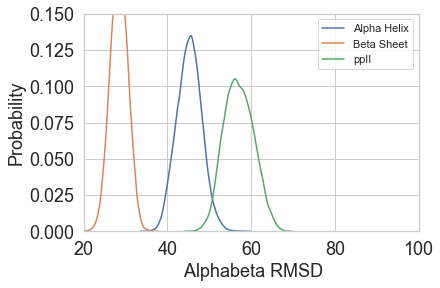

In [86]:
def alphabeta_rmsd(phi,psi,phi_ref,psi_ref):
 alphabetarmsd=np.sum(0.5*(1+np.cos(psi-psi_ref)),axis=1)+np.sum(0.5*(1+np.cos(phi-phi_ref)),axis=1)
 return alphabetarmsd 

#Phi_all=np.loadtxt(phipsi_dir+'/Phi.dat')[0:-1]
#Psi_all=np.loadtxt(phipsi_dir+'/Psi.dat')[0:-1]
Phi_all=phis
Psi_all=psis
alphabeta_alpharight=alphabeta_rmsd(Phi_all,Psi_all,-1.05,-0.79)
alphabeta_betasheet=alphabeta_rmsd(Phi_all,Psi_all,2.36,-2.36)
alphabeta_ppII=alphabeta_rmsd(Phi_all,Psi_all,-1.31,2.71)

#sns.set(style='whitegrid')
sns.kdeplot(data=alphabeta_alpharight,label='Alpha Helix')
sns.kdeplot(data=alphabeta_betasheet,label='Beta Sheet')
sns.kdeplot(data=alphabeta_ppII,label='ppII')

plt.xlabel(' Alphabeta RMSD',fontsize=18)
plt.ylabel('Probability',fontsize=18)
plt.xlim(20,100)
plt.ylim(0,0.15)

plt.legend(loc='upper right')
plt.tick_params(labelsize=18)

plt.show()

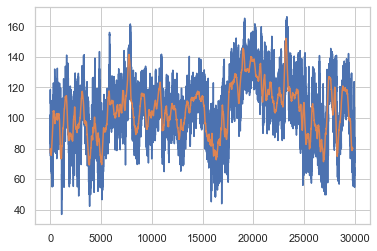

In [68]:
N=200
plt.plot(wtot)
plt.plot(np.convolve(wtot,np.ones(N)/N,mode='valid'))

29977


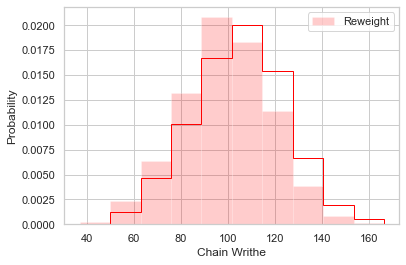

In [80]:
print(len(wtot))
plt.hist(wtot[0:-1],histtype='step',density='true',color='red')
plt.hist(wtot[0:-1],weights=final_weights,alpha=0.2,density='true',label='Reweight',color='red')


plt.xlabel('Chain Writhe',fontsize=12)
plt.ylabel('Probability',fontsize=12)
plt.legend(loc='upper right')

plt.show()


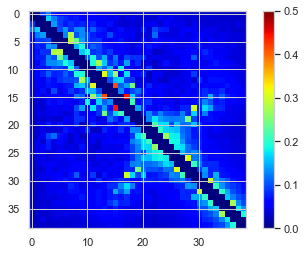

In [81]:
#Visualize Average Writhe Values in NxN Matrix 
writhe_matrx=np.zeros((len(CAlabel)-1,len(CAlabel)-1))
for j in wr_total:
   for k in wr_total[j]:
     writhe_matrx[j,k]=np.average(wr_total[j][k])
        
#print(writhe_matrx)
plt.imshow(writhe_matrx,cmap='jet',vmin=0, vmax=0.50)
plt.colorbar()

#wr_total[j][k]

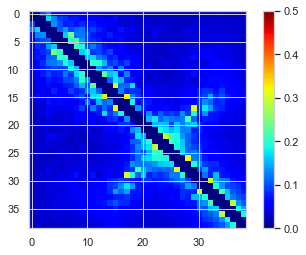

In [82]:
writhe_matrx=np.zeros((len(CAlabel)-1,len(CAlabel)-1))

for j in wr_total:
    for k in wr_total[j]:
      a=np.asarray(wr_total[j][k])
      if a.all()!= 0:
       writhe_matrx[j,k]=np.dot(a[0:-1],final_weights)
      else : 
       writhe_matrx[j,k]=0
    
#print(writhe_matrx)
plt.imshow(writhe_matrx,cmap='jet',vmin=0, vmax=0.50)
plt.colorbar()

#wr_total[j][k]

In [99]:
#print(np.array(CAlabel).astype(int))

contact_maps = []
contact_distances = []
for i in range(1,40):
    contact_map = []
    contact_distance = []
    for j in range(1,40):
        if i == j:
            contacts = 0
        else:
            dist = md.compute_contacts(trj,[[i,j]])
            array = np.asarray(dist[0]).astype(float)
            distance = np.average(array)
            #distance = np.dot(array,final_weights
            contact_distance.append(distance)
            contact = np.where(array < 1.2, 1, 0)
            contacts = np.average(contact)
            #contacts = np.dot(contact,final_weights)
        contact_map.append(contacts)
    contact_maps.append(contact_map)
    contact_distances.append(contact_distance)
final_map = np.asarray(contact_maps).astype(float)
final_distance = np.asarray(contact_distances).astype(float)

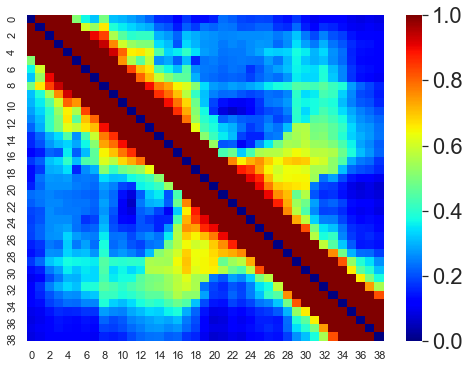

In [108]:
contact_map = final_map
#sequence = ['LEU391', '', '', '', '', 'ALA396', '', '', '', '', 'ALA401', '', '', '', '', 'TYR406', '', '', '', '', 'SER411', '', '', '', '', 'GLY416',
#            '', '', '', '', 'GLY421', '', '', '', '', 'SER426', '', '', '', '', 'SER431', '', '', '', '', 'LEU436', '', '', '', '', 'GLU441', '', '', '', '', 'GLY446']

# Make distance map
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
im = sns.heatmap(contact_map, cmap = 'jet', ax = ax)
ax.grid(which='both', alpha=0.5)
#plt.xticks(range(1,57), sequence, rotation=45, size=14)
#plt.yticks(range(1, 57), sequence, rotation=45, size=14)
cbar = im.collections[0].colorbar
# cbar = fig.colorbar(im)
cbar.ax.tick_params(labelsize=22)
#ax.invert_yaxis()

#plt.savefig(workdir+'contact_map.png')
#plt.savefig(workdir+'contact_map.pdf')
plt.show()


In [135]:
#print(np.array(CAlabel).astype(int))
#Reweight Contact Map 
contact_maps = []
contact_distances = []
for i in range(1,40):
    contact_map = []
    contact_distance = []
    for j in range(1,40):
        if i == j:
            contacts = 0
        else:
            dist = md.compute_contacts(trj,[[i,j]])
            array = np.asarray(dist[0]).astype(float)
            #distance = np.average(array)
            distance = np.dot(array[:,0][0:-1],final_weights)
            contact_distance.append(distance)
            contact = np.where(array[:,0][0:-1] < 1.2, 1, 0)
            #contacts = np.average(contact)
            contacts = np.dot(contact,final_weights)
        contact_map.append(contacts)
    contact_maps.append(contact_map)
    contact_distances.append(contact_distance)
final_map = np.asarray(contact_maps).astype(float)
final_distance = np.asarray(contact_distances).astype(float)

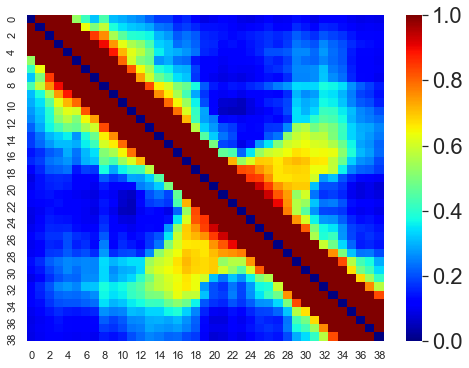

In [129]:
contact_map = final_map
#sequence = ['LEU391', '', '', '', '', 'ALA396', '', '', '', '', 'ALA401', '', '', '', '', 'TYR406', '', '', '', '', 'SER411', '', '', '', '', 'GLY416',
#            '', '', '', '', 'GLY421', '', '', '', '', 'SER426', '', '', '', '', 'SER431', '', '', '', '', 'LEU436', '', '', '', '', 'GLU441', '', '', '', '', 'GLY446']

# Make distance map
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
im = sns.heatmap(contact_map, cmap = 'jet', ax = ax)
ax.grid(which='both', alpha=0.5)
#plt.xticks(range(1,57), sequence, rotation=45, size=14)
#plt.yticks(range(1, 57), sequence, rotation=45, size=14)
cbar = im.collections[0].colorbar
# cbar = fig.colorbar(im)
cbar.ax.tick_params(labelsize=22)
#ax.invert_yaxis()

#plt.savefig(workdir+'contact_map.png')
#plt.savefig(workdir+'contact_map.pdf')
plt.show()


Rg vs. Total Writhe


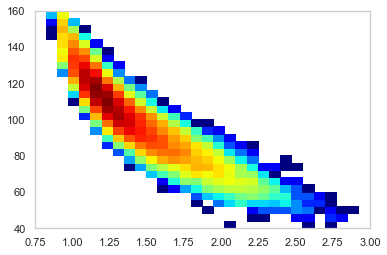

In [130]:
hist=plt.hist2d(rg,wtot[0:-1],bins=30,norm=colors.LogNorm(),range=[[0.75,3.0],[40,160]],cmap='jet')
print("Rg vs. Total Writhe")

Rg vs. Total Writhe


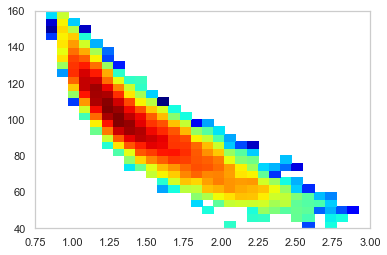

In [131]:
hist=plt.hist2d(rg,wtot[0:-1],bins=30,weights=final_weights,range=[[0.75,3.0],[40,160]],norm=colors.LogNorm(),cmap='jet')
print("Rg vs. Total Writhe")

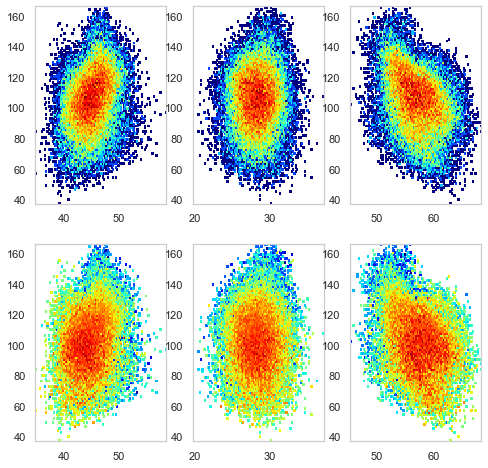

In [132]:
fig, ax = plt.subplots(2,3, figsize=((8,8)))
hist_i=ax[0,0].hist2d(alphabeta_alpharight[0:-1],wtot[0:-1],bins=100,norm=colors.LogNorm(),cmap='jet')
hist_r=ax[1,0].hist2d(alphabeta_alpharight[0:-1],wtot[0:-1],bins=100, weights=final_weights, norm=colors.LogNorm(),cmap='jet')

hist_i=ax[0,1].hist2d(alphabeta_betasheet[0:-1],wtot[0:-1],bins=100,norm=colors.LogNorm(),cmap='jet')
hist_r=ax[1,1].hist2d(alphabeta_betasheet[0:-1],wtot[0:-1],bins=100,weights=final_weights, norm=colors.LogNorm(),cmap='jet')

hist_i=ax[0,2].hist2d(alphabeta_ppII[0:-1],wtot[0:-1],bins=100,norm=colors.LogNorm(),cmap='jet')
hist_r=ax[1,2].hist2d(alphabeta_ppII[0:-1],wtot[0:-1],bins=100,weights=final_weights, norm=colors.LogNorm(),cmap='jet')

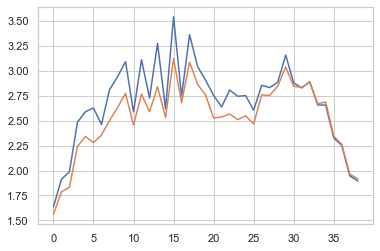

In [133]:
w_by_res=[]
w_by_res_reweight=[]

for i in writhe_by_res:
    #print(i,np.average(writhe_by_res[i]))
    w_by_res.append(np.average(writhe_by_res[i]))
    w_by_res_reweight.append(np.dot(writhe_by_res[i][0:-1],final_weights))

plt.plot(w_by_res)
plt.plot(w_by_res_reweight)


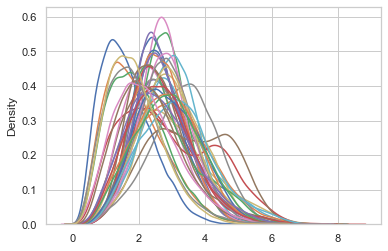

In [134]:
for i in writhe_by_res:
 sns.kdeplot(writhe_by_res[i],label=i)
#plt.legend(loc='upper right')
plt.show()